In [1]:
import sqlite3

from collections import Counter

import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
S1 = "3 agree on A/B"
S2 = "2 agree on A/B, 1 dissenting"
S3 = "2 agree on A/B, 1 unsure"
S4 = "2 disagree on A/B, 1 unsure"
S5 = "2 unsure, 1 vote A/B"
S6 = "3 unsure"

SUMMARIES = {
    "AAA": S1,
    "BBB": S1,
    "AAB": S2,
    "ABB": S2,
    "AAU": S3,
    "BBU": S3,
    "ABU": S4,
    "AUU": S5,
    "BUU": S5,
    "UUU": S6,
}

CU = "Usable"
CN = "Not Usable"

CATEGORIES = {
    S1: CU,
    S2: CN,
    S3: CU,
    S4: CN,
    S5: CU,
    S6: CN
}

def to_vote_string(votes: Counter[str]):
    if votes.total() != 3:
        raise RuntimeError()
    if not (set(votes.keys()) <= {"A", "B", "U"}):
        raise RuntimeError()
    return "".join(sorted(votes.elements()))

In [3]:
sql = """
    SELECT
        I.id AS pair_id,
        S.name AS sequence_name,
        PA.name AS a_project,
        FA.filename AS a_name,
        FA.content AS a_content,
        PB.name AS b_project,
        FB.filename AS b_name,
        FB.content AS b_content,
        U.username,
        R.value
    FROM fileranker_response R
    JOIN auth_user U ON U.id = R.user_id
    JOIN fileranker_sequenceitem I ON I.id = R.item_id
    JOIN fileranker_sequence S ON S.id = I.sequence_id
    JOIN fileranker_file FA ON FA.id = I.file_a_id
    JOIN fileranker_file FB ON FB.id = I.file_b_id
    JOIN fileranker_project PA ON PA.id = FA.project_id
    JOIN fileranker_project PB ON PB.id = FB.project_id
    WHERE S.name = 'survey_loc_adjusted'
    ORDER BY I.position, U.id
"""

res_df = pd.read_sql(sql=sql, con=sqlite3.connect("results2.sqlite3"))
res_df = res_df[~(res_df["username"] == "admin")]
res_df.insert(3, "a_loc", [len(c.split("\n")) for c in res_df["a_content"]])
res_df.insert(5, "b_loc", [len(c.split("\n")) for c in res_df["b_content"]])
res_df = res_df.drop(["a_content", "b_content"], axis=1)
res_df

,pair_id,sequence_name,a_project,a_loc,a_name,b_loc,b_project,b_name,username,value
1,21038,survey_loc_adjusted,survey3,141,src/SurveyMenu.java,139,survey6,src/Question/ValidDateQuestion.java,chipmunk,A
2,21038,survey_loc_adjusted,survey3,141,src/SurveyMenu.java,139,survey6,src/Question/ValidDateQuestion.java,jackal,U
3,21038,survey_loc_adjusted,survey3,141,src/SurveyMenu.java,139,survey6,src/Question/ValidDateQuestion.java,wildcat,U
5,21039,survey_loc_adjusted,survey5,17,src/main/java/Essay.java,19,survey6,src/Import/Import.java,chipmunk,A
6,21039,survey_loc_adjusted,survey5,17,src/main/java/Essay.java,19,survey6,src/Import/Import.java,jackal,U
...,...,...,...,...,...,...,...,...,...,...
166,21087,survey_loc_adjusted,survey2,20,src/question/TrueFalseQuestion.java,19,survey6,src/Import/Import.java,chipmunk,A
167,21087,survey_loc_adjusted,survey2,20,src/question/TrueFalseQuestion.java,19,survey6,src/Import/Import.java,jackal,U
168,21087,survey_loc_adjusted,survey2,20,src/question/TrueFalseQuestion.java,19,survey6,src/Import/Import.java,wildcat,U
169,21088,survey_loc_adjusted,survey6,207,src/Question/CheckBoxQuestion.java,206,survey6,src/Question/MultipleChoiceQuestion.java,chipmunk,B


In [4]:
res_df.to_csv("reports/votes_raw2.csv")

In [5]:
vote_strings = []
consensus_rows = []
groups = res_df.groupby(["pair_id", "a_project", "a_name", "b_project", "b_name"])

for (pair_id, a_proj, a_name, b_proj, b_name), group_df in groups:
    votes = Counter(group_df["value"])
    if votes.total() != 3:
        continue
    vote_string = to_vote_string(votes)
    vote_strings.append(vote_string)
    if CATEGORIES[SUMMARIES[vote_string]] != CU:
        continue
    votes["U"] = 0
    if votes.most_common(1)[0][0] == "A":
        consensus_rows.append({
            "p_proj": a_proj,
            "p_name": a_name,
            "n_proj": b_proj,
            "n_name": b_name,
        })
    elif votes.most_common(1)[0][0] == "B":
        consensus_rows.append({
            "p_proj": b_proj,
            "p_name": b_name,
            "n_proj": a_proj,
            "n_name": a_name,
        })

consensus_df = pd.DataFrame.from_records(consensus_rows)
consensus_df

,p_proj,p_name,n_proj,n_name
0,survey3,src/SurveyMenu.java,survey6,src/Question/ValidDateQuestion.java
1,survey5,src/main/java/Essay.java,survey6,src/Import/Import.java
2,survey1,src/com/surveysystem/util/Output.java,survey3,src/utils/FSConfig.java
3,survey6,src/OutputHandler/OutputHandlerFactory.java,survey5,src/main/java/ReadableJSONExportStrategy.java
4,survey2,src/ui/GUI.java,survey3,src/SurveyFormPanel.java
5,survey6,src/Import/SerializerImport.java,survey6,src/Survey/Survey.java
6,survey1,src/YamlLoader.java,survey1,src/com/surveysystem/io/XMLOutput.java
7,survey2,src/ui/GUI.java,survey6,src/Question/LinearScaleQuestion.java
8,survey1,src/com/surveysystem/util/YamlLoader.java,survey5,src/main/java/Checkbox.java
9,survey1,src/com/surveysystem/util/Output.java,survey5,src/main/java/TestMenu.java


In [6]:
consensus_rows = []

for _, row in res_df[res_df["username"] == "wildcat"][0:50].iterrows():
    if row["value"] == "U":
        continue
    if row["value"] == "A":
        consensus_rows.append({
            "p_proj": row["a_project"],
            "p_name": row["a_name"],
            "n_proj": row["b_project"],
            "n_name": row["b_name"],
        })
    elif row["value"] == "B":
        consensus_rows.append({
            "p_proj": row["b_project"],
            "p_name": row["b_name"],
            "n_proj": row["a_project"],
            "n_name": row["a_name"],
        })

consensus_df = pd.DataFrame.from_records(consensus_rows)
consensus_df

,p_proj,p_name,n_proj,n_name
0,survey1,src/com/surveysystem/util/Output.java,survey3,src/utils/FSConfig.java
1,survey6,src/Menu/MenuOptions/LoadOption.java,survey3,src/Menu.java
2,survey2,src/ui/GUI.java,survey3,src/SurveyFormPanel.java
3,survey6,src/Import/SerializerImport.java,survey6,src/Survey/Survey.java
4,survey1,src/YamlLoader.java,survey1,src/com/surveysystem/io/XMLOutput.java
5,survey1,src/com/surveysystem/question/Response.java,survey6,src/Menu/SurveyMenu.java
6,survey2,src/ui/GUI.java,survey6,src/Question/LinearScaleQuestion.java
7,survey3,src/Matching.java,survey6,src/AbstractFactory/TerminalQuestionFactory.java
8,survey1,src/com/surveysystem/util/Output.java,survey5,src/main/java/TestMenu.java
9,survey3,src/MainMenu.java,survey5,src/main/java/QuestionWithOptions.java


<Axes: xlabel='count'>

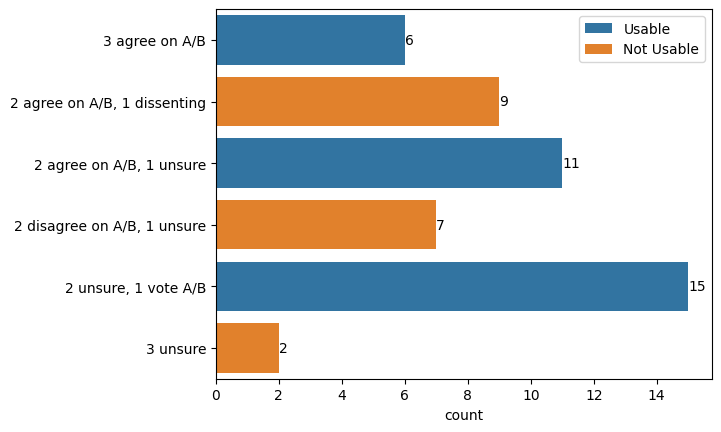

In [7]:
summaries = [SUMMARIES[v] for v in vote_strings]
categories = [CATEGORIES[s] for s in summaries]
ax = sns.countplot(y=summaries, hue=categories, order=[S1, S2, S3, S4, S5, S6])
for container in ax.containers:
    ax.bar_label(container)
ax

In [8]:
def to_team_id(db_name: str) -> int:
    return int(db_name.split("/")[-1].split("_")[0][-1])

lcom_df = pd.read_excel("reports/report_survey.xlsx")
lcom_df.insert(0, "project", [f"survey{to_team_id(d)}" for d in lcom_df["DB"]])
lcom_df = lcom_df.drop(["DB", "Name", "Kind"], axis=1)

def get_score(project, filename, score_name, *, per_loc: bool):
    df = lcom_df[(lcom_df["project"] == project) & (lcom_df["Filename"] == filename)]
    if len(df) != 1:
        raise RuntimeError
    if not per_loc:
        return df.iloc[0][score_name]
    return df.iloc[0][score_name] / df.iloc[0]["[E] LOC"]
    
lcom_df

,project,Filename,[E] LOC,[E] Entities,[E] Fields,[E] Methods,[C] LCOM1,[C] LCOM2,[C] LCOM3,[C] MSC1,[C] MSC2,[C] MSC3,[C] MSC4
0,survey1,src/YamlLoader.java,28,2,1,1,0,0.000000,NaN,1.467331,1.467336,4.306150,4.306150
1,survey1,src/com/surveysystem/form/Survey.java,45,10,3,7,15,0.714286,0.833333,2.370305,3.228553,6.431171,3.108965
2,survey1,src/com/surveysystem/io/CSVInput.java,33,4,0,4,6,NaN,NaN,2.256124,2.691698,6.880228,3.375875
3,survey1,src/com/surveysystem/io/CSVOutput.java,70,3,0,3,3,NaN,NaN,2.255224,2.541165,7.724497,5.053195
4,survey1,src/com/surveysystem/io/InputStrategy.java,18,3,0,3,3,NaN,NaN,2.068788,2.373027,6.494263,4.251490
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,survey7,src/main/java/TakenSurvey.java,22,4,1,3,3,0.666667,1.000000,2.278257,2.523849,7.072925,3.874886
181,survey7,src/main/java/TestPanel.java,116,3,2,1,0,0.000000,NaN,2.256038,2.543164,7.716712,4.979432
182,survey7,src/main/java/TestResponse.java,54,15,6,9,33,0.870370,0.979167,2.728239,3.432583,8.135342,2.646065
183,survey7,src/main/java/TrueFalseQuestion.java,37,7,2,5,10,1.000000,1.250000,2.586631,3.204678,7.985504,2.823066


In [9]:
consensus_df["p_loc"] = [get_score(r["p_proj"], r["p_name"], "[E] LOC", per_loc=False) for _, r in consensus_df.iterrows()]
consensus_df["p_lcom1"] = [get_score(r["p_proj"], r["p_name"], "[C] LCOM1", per_loc=False) for _, r in consensus_df.iterrows()]
consensus_df["p_lcom2"] = [get_score(r["p_proj"], r["p_name"], "[C] LCOM2", per_loc=False) for _, r in consensus_df.iterrows()]
consensus_df["p_lcom3"] = [get_score(r["p_proj"], r["p_name"], "[C] LCOM3", per_loc=False) for _, r in consensus_df.iterrows()]
consensus_df["p_msc1"] = [get_score(r["p_proj"], r["p_name"], "[C] MSC1", per_loc=False) for _, r in consensus_df.iterrows()]
consensus_df["p_msc2"] = [get_score(r["p_proj"], r["p_name"], "[C] MSC2", per_loc=False) for _, r in consensus_df.iterrows()]

consensus_df["n_loc"] = [get_score(r["n_proj"], r["n_name"], "[E] LOC", per_loc=False) for _, r in consensus_df.iterrows()]
consensus_df["n_lcom1"] = [get_score(r["n_proj"], r["n_name"], "[C] LCOM1", per_loc=False) for _, r in consensus_df.iterrows()]
consensus_df["n_lcom2"] = [get_score(r["n_proj"], r["n_name"], "[C] LCOM2", per_loc=False) for _, r in consensus_df.iterrows()]
consensus_df["n_lcom3"] = [get_score(r["n_proj"], r["n_name"], "[C] LCOM3", per_loc=False) for _, r in consensus_df.iterrows()]
consensus_df["n_msc1"] = [get_score(r["n_proj"], r["n_name"], "[C] MSC1", per_loc=False) for _, r in consensus_df.iterrows()]
consensus_df["n_msc2"] = [get_score(r["n_proj"], r["n_name"], "[C] MSC2", per_loc=False) for _, r in consensus_df.iterrows()]

In [10]:
consensus_df["loc"] = consensus_df["p_loc"] < consensus_df["n_loc"]
consensus_df["lcom1"] = consensus_df["p_lcom1"] < consensus_df["n_lcom1"]
consensus_df["lcom2"] = consensus_df["p_lcom2"] < consensus_df["n_lcom2"]
consensus_df["lcom3"] = consensus_df["p_lcom3"] < consensus_df["n_lcom3"]
consensus_df["msc1"] = consensus_df["p_msc1"] < consensus_df["n_msc1"]
consensus_df["msc2"] = consensus_df["p_msc2"] < consensus_df["n_msc2"]

In [11]:
consensus_df.to_csv("reports/votes_consensus2.csv")

In [12]:
print("LOC: {}".format(consensus_df["loc"].sum() / len(consensus_df)))
print("LCOM1: {}".format(consensus_df["lcom1"].sum() / len(consensus_df)))
print("LCOM2: {}".format(consensus_df["lcom2"].sum() / len(consensus_df)))
print("LCOM3: {}".format(consensus_df["lcom3"].sum() / len(consensus_df)))
print("MSC1: {}".format(consensus_df["msc1"].sum() / len(consensus_df)))
print("MSC2: {}".format(consensus_df["msc2"].sum() / len(consensus_df)))

LOC: 0.5
LCOM1: 0.53125
LCOM2: 0.25
LCOM3: 0.25
MSC1: 0.5625
MSC2: 0.59375


In [13]:
Yuanfang
LOC: 0.5365853658536586
LCOM1: 0.5853658536585366
LCOM2: 0.34146341463414637
LCOM3: 0.34146341463414637
MSC1: 0.6097560975609756
MSC2: 0.5121951219512195

Rick
LOC: 0.5217391304347826
LCOM1: 0.8260869565217391
LCOM2: 0.43478260869565216
LCOM3: 0.391304347826087
MSC1: 0.7391304347826086
MSC2: 0.8695652173913043

Ernie
LOC: 0.5
LCOM1: 0.53125
LCOM2: 0.25
LCOM3: 0.25
MSC1: 0.5625
MSC2: 0.59375



NameError: name 'Yuanfang' is not defined